#### 1. Imports

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
from scipy.stats import norm, qmc
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel as C
import matplotlib.pyplot as plt

#### 2. Paths & Data loading

In [2]:
# --- Paths ---

BASE_DIR = Path.cwd()
DATA_DIR = BASE_DIR.parent / "initial_data" / "function_4"

# --- Load initial data ---
X = np.load(DATA_DIR / "initial_inputs.npy", allow_pickle=True)
y = np.load(DATA_DIR / "initial_outputs.npy", allow_pickle=True).ravel()
X = np.asarray(X, float)
y = np.asarray(y, float)
print(f"Loaded X:{X.shape}, y:{y.shape}")

Loaded X:(30, 4), y:(30,)


#### 3. Add weekly data

In [3]:
# --- Weekly results ---

week_data = [
    (np.array([
0.44739007,0.4067464,0.37675635,0.39856218]), -0.0784261573095999),  # W1
    (np.array([0.400828, 0.42327 , 0.353541, 0.436252]),  0.48178123910921444), # W2
    (np.array([0.399923, 0.481496, 0.417614, 0.455103]),  -1.4246305565060235), # W3
    (np.array([0.406434, 0.391599, 0.280729, 0.430719]),  -1.2327939637160834), # W4
    (np.array([0.403822, 0.370930, 0.380299, 0.413288]),   0.4677117968250397), # W5
    (np.array([0.373995, 0.385767, 0.388072, 0.424855]),  0.30235177543176706), # W6
    (np.array([0.402349, 0.368343, 0.410278, 0.426186]), 0.5998487698050465), # W7
]

X_prev, y_prev = X.copy(), y.copy()

for x_new, y_new in week_data:
    X = np.vstack([X, x_new])
    y = np.append(y, y_new)

print(f"Updated shapes → X:{X.shape}, y:{y.shape}")

Updated shapes → X:(37, 4), y:(37,)


#### 4. Quick Visualization

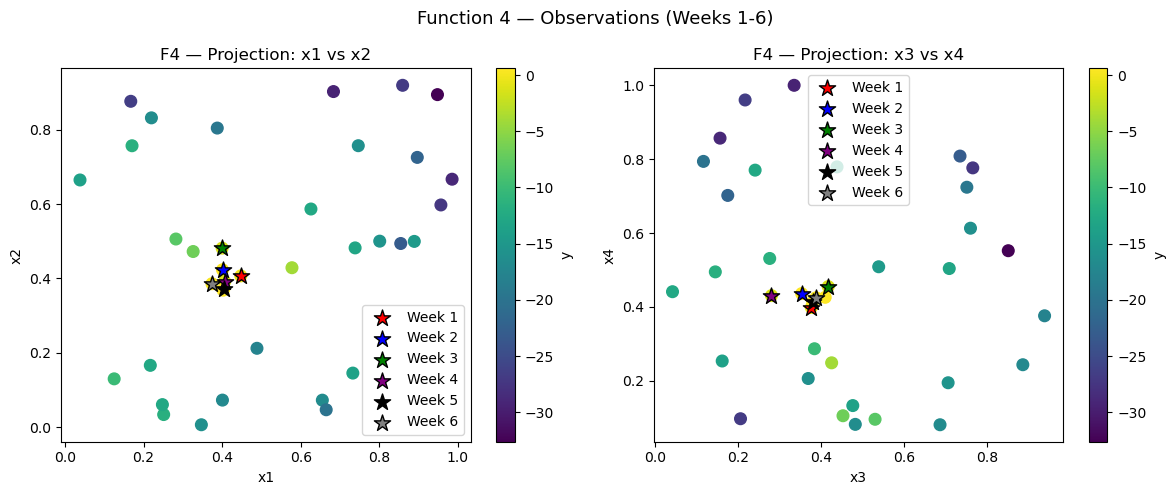

In [4]:

# --- Simple 2D projections of the 4D space ---
# We'll plot (x1 vs x2) and (x3 vs x4) as representative slices.
fig, axes = plt.subplots(1, 2, figsize=(12,5))

# --- Projection 1: x1-x2 ---
sc1 = axes[0].scatter(X[:,0], X[:,1], c=y, cmap='viridis', s=70)
axes[0].scatter(week_data[0][0][0], week_data[0][0][1], c='red', s=150, edgecolors='k', marker='*', label='Week 1')
axes[0].scatter(week_data[1][0][0], week_data[1][0][1], c='blue', s=150, edgecolors='k', marker='*', label='Week 2')
axes[0].scatter(week_data[2][0][0], week_data[2][0][1], c='green', s=150, edgecolors='k', marker='*', label='Week 3')
axes[0].scatter(week_data[3][0][0], week_data[3][0][1], c='purple', s=150, edgecolors='k', marker='*', label='Week 4')
axes[0].scatter(week_data[4][0][0], week_data[4][0][1], c='black', s=150, edgecolors='k', marker='*', label='Week 5')
axes[0].scatter(week_data[5][0][0], week_data[5][0][1], c='grey', s=150, edgecolors='k', marker='*', label='Week 6')
axes[0].set_xlabel('x1'); axes[0].set_ylabel('x2')
axes[0].set_title('F4 — Projection: x1 vs x2')
axes[0].legend(loc='best')
fig.colorbar(sc1, ax=axes[0], label='y')

# --- Projection 2: x3-x4 ---
sc2 = axes[1].scatter(X[:,2], X[:,3], c=y, cmap='viridis', s=70)
axes[1].scatter(week_data[0][0][2], week_data[0][0][3], c='red', s=150, edgecolors='k', marker='*', label='Week 1')
axes[1].scatter(week_data[1][0][2], week_data[1][0][3], c='blue', s=150, edgecolors='k', marker='*', label='Week 2')
axes[1].scatter(week_data[2][0][2], week_data[2][0][3], c='green', s=150, edgecolors='k', marker='*', label='Week 3')
axes[1].scatter(week_data[3][0][2], week_data[3][0][3], c='purple', s=150, edgecolors='k', marker='*', label='Week 4')
axes[1].scatter(week_data[4][0][2], week_data[4][0][3], c='black', s=150, edgecolors='k', marker='*', label='Week 5')
axes[1].scatter(week_data[5][0][2], week_data[5][0][3], c='grey', s=150, edgecolors='k', marker='*', label='Week 6')
axes[1].set_xlabel('x3'); axes[1].set_ylabel('x4')
axes[1].set_title('F4 — Projection: x3 vs x4')
axes[1].legend(loc='best')
fig.colorbar(sc2, ax=axes[1], label='y')

plt.suptitle('Function 4 — Observations (Weeks 1-6)', fontsize=13)
plt.tight_layout()
plt.show()

#### 5.1 Gaussian Process Model

In [5]:
# --- W8 KERNEL: Widen bounds to handle x1 convergence warning ---
# Previous kernel had x1 length_scale hitting upper bound (3.0)

kernel = (
    C(1.0, (1e-2, 1e2)) *
    Matern(length_scale=np.ones(4)*0.5, nu=1.5, 
           length_scale_bounds=(1e-3, 5.0))  # widened from 3.0
    + WhiteKernel(noise_level=1e-3, noise_level_bounds=(1e-5, 0.1))
)

gp = GaussianProcessRegressor(
    kernel=kernel,
    normalize_y=True,
    n_restarts_optimizer=15,
    alpha=1e-6,
    random_state=0
)

gp.fit(X, y)
print("[F4] W8 Fitted kernel:", gp.kernel_)

[F4] W8 Fitted kernel: 4.53**2 * Matern(length_scale=[3.57, 3.21, 3.31, 3.39], nu=1.5) + WhiteKernel(noise_level=0.00123)


#### 5.2 Trust region an dsampling strategy

In [6]:
# --- W8 STRATEGY: Aggressive exploitation of W7 breakthrough ---

from scipy.stats import qmc

def lhs(lb, ub, n, seed):
    d = lb.size
    sampler = qmc.LatinHypercube(d=d, seed=seed)
    U = sampler.random(n)
    return lb + U * (ub - lb)

print("[F4] W8 Strategy: Exploit W7 (new best: 0.600, +25% vs W2)")

# --- W8 CHANGE: Anchor at W7 (NEW BEST) ---
best_idx = np.argmax(y)
anchor = X[best_idx]  # W7: [0.402, 0.368, 0.410, 0.426]

# Use full domain
lb = np.zeros(4)
ub = np.ones(4)

# --- W8 CHANGE: TIGHTEN trust region around W7 ---
L = 0.30  # DOWN from 0.40 - aggressive exploitation of new best

lb_tr = np.clip(anchor - 0.5 * L, 0, 1)
ub_tr = np.clip(anchor + 0.5 * L, 0, 1)

print(f"  Anchor (W7, new best): {anchor}")
print(f"  Trust Region L: {L} (tightened from 0.40)")
print(f"  TR bounds:")
for i in range(4):
    print(f"    x{i+1}: [{lb_tr[i]:.3f}, {ub_tr[i]:.3f}]")

# --- W8 CHANGE: Increase TR sampling (80/20 split) ---
N_total = 70000
N_tr = 56000   # 80% TR (up from 75%)
N_gl = 14000   # 20% global (down from 25%)

# --- W8 ADDITION: Focused sampling on critical dimensions ---
# W2→W7 analysis showed: x2 should decrease, x3 should increase
N_focused = 5000
rng_focused = np.random.default_rng(seed=4080)

# Generate focused samples exploring x2/x3 directions
focused_samples = []
for _ in range(N_focused):
    sample = anchor.copy()
    # Vary x2 (lower range: 0.35-0.39)
    sample[1] = rng_focused.uniform(0.35, 0.39)
    # Vary x3 (higher range: 0.39-0.43)
    sample[2] = rng_focused.uniform(0.39, 0.43)
    # Small perturbations in x1, x4
    sample[0] += rng_focused.normal(0, 0.01)
    sample[3] += rng_focused.normal(0, 0.01)
    sample = np.clip(sample, 0, 1)
    focused_samples.append(sample)

C_focused = np.array(focused_samples)

# Standard sampling
C_tr = lhs(lb_tr, ub_tr, N_tr, seed=4081)
C_gl = lhs(lb, ub, N_gl, seed=4082)
Cands = np.vstack([C_tr, C_gl, C_focused])

print(f"  Candidates: {N_tr} TR (80%) + {N_gl} global (20%) + {N_focused} focused (7%)")
print(f"  Focused sampling on x2 ↓ [0.35-0.39] and x3 ↑ [0.39-0.43]")

[F4] W8 Strategy: Exploit W7 (new best: 0.600, +25% vs W2)
  Anchor (W7, new best): [0.402349 0.368343 0.410278 0.426186]
  Trust Region L: 0.3 (tightened from 0.40)
  TR bounds:
    x1: [0.252, 0.552]
    x2: [0.218, 0.518]
    x3: [0.260, 0.560]
    x4: [0.276, 0.576]
  Candidates: 56000 TR (80%) + 14000 global (20%) + 5000 focused (7%)
  Focused sampling on x2 ↓ [0.35-0.39] and x3 ↑ [0.39-0.43]


#### Adquisition and Selection (EI -> UCB -> MAxVar)

In [7]:
# --- W8 ACQUISITION: Aggressive exploitation with EI ---

import numpy as np
from scipy.stats import norm

# --- Helpers ---
def too_close_Linf(c, X, tol=0.025):
    """Reject candidate if L_inf distance to any existing point is < tol."""
    return np.any(np.max(np.abs(X - c), axis=1) < tol)

# --- GP prediction on candidates ---
mu, sigma = gp.predict(Cands, return_std=True)
sigma = np.maximum(sigma, 1e-12)

# --- W8 CHANGE: REDUCE xi for aggressive exploitation ---
y_best = y.max()
xi = 0.01  # DOWN from 0.02 - exploit W7 breakthrough

improve = mu - y_best - xi
Z = improve / sigma
ei = improve * norm.cdf(Z) + sigma * norm.pdf(Z)
ei[sigma < 1e-12] = 0.0

print(f"  Exploration param xi: {xi} (reduced for exploitation)")

# --- Anti-edge mask (avoid border artifacts near 0/1) ---
edge_eps = 1e-3
mask_edges = np.all((Cands > edge_eps) & (Cands < 1 - edge_eps), axis=1)
ei_masked = np.where(mask_edges, ei, -np.inf)

# --- Select best EI candidate with de-duplication ---
order = np.argsort(-ei_masked)
x_next, chosen = None, "EI"
for idx in order:
    cand = Cands[idx]
    if not too_close_Linf(cand, X, tol=0.025):
        x_next = cand
        break

# --- Fallback 1: Upper Confidence Bound (UCB) if EI is degenerate ---
if (x_next is None) or (not np.isfinite(ei_masked).any()) or (np.nanmax(ei_masked) <= 0):
    kappa = 1.5  # reduced from 2.0 for more exploitation
    ucb = mu + kappa * sigma
    ucb_masked = np.where(mask_edges, ucb, -np.inf)
    for idx in np.argsort(-ucb_masked):
        cand = Cands[idx]
        if not too_close_Linf(cand, X, tol=0.025):
            x_next = cand
            chosen = "UCB"
            break

# --- Fallback 2: Max variance (pure exploration) ---
if x_next is None:
    var_masked = np.where(mask_edges, sigma, -np.inf)
    for idx in np.argsort(-var_masked):
        cand = Cands[idx]
        if not too_close_Linf(cand, X, tol=0.025):
            x_next = cand
            chosen = "MaxVar"
            break

# --- Output and analysis ---
print(f"\n[F4] Chosen by {chosen}: {x_next}")
print("Submission format:")
print(" - ".join(f"{v:.6f}" for v in x_next))

# --- Validation ---
print("\nValidation:")
print("  Within [0,1]? ", np.all((x_next >= 0) & (x_next <= 1)))
print("  Near-duplicate (L_inf < 0.025)? ", too_close_Linf(x_next, X, tol=0.025))

# --- Comparison to W7 (new best) ---
dist_to_w7 = np.linalg.norm(x_next - anchor)
print(f"\nComparison to W7 (best):")
print(f"  Distance to W7: {dist_to_w7:.4f}")
print(f"  Δx1: {x_next[0] - anchor[0]:+.4f}")
print(f"  Δx2: {x_next[1] - anchor[1]:+.4f} (critical: should ↓)")
print(f"  Δx3: {x_next[2] - anchor[2]:+.4f} (critical: should ↑)")
print(f"  Δx4: {x_next[3] - anchor[3]:+.4f}")
print(f"  Search mode: {'Tight exploitation' if dist_to_w7 < 0.08 else 'Moderate refinement'}")

  Exploration param xi: 0.01 (reduced for exploitation)

[F4] Chosen by EI: [0.40691087 0.35985799 0.40328036 0.45531765]
Submission format:
0.406911 - 0.359858 - 0.403280 - 0.455318

Validation:
  Within [0,1]?  True
  Near-duplicate (L_inf < 0.025)?  False

Comparison to W7 (best):
  Distance to W7: 0.0315
  Δx1: +0.0046
  Δx2: -0.0085 (critical: should ↓)
  Δx3: -0.0070 (critical: should ↑)
  Δx4: +0.0291
  Search mode: Tight exploitation


In [8]:
w2 = np.array([0.400828, 0.423270, 0.353541, 0.436252])
cand = np.array([0.37399503, 0.38576706, 0.38807156, 0.42485526])
print("L_inf to W2:", np.max(np.abs(cand - w2)))

L_inf to W2: 0.037502939999999985


### Reflection — Function 4 
#### Week 1

- Initial results were unstable, with outputs around **-0.078**, suggesting the function had noise or multiple shallow regions.  
- The model focused on **exploration**, sampling a moderate range to understand the surface structure.  
- Strategy centered on wide **Matern kernel (ν=1.5)** with high noise tolerance to handle uncertainty.  
- Plan for next round: refine the kernel, keep exploration ratio around 50%, and start identifying stable areas of improvement.  

---

#### Week 2
- Significant improvement: output jumped from **-0.078 → 0.482**, marking a clear performance gain.  
- The function appears **noisy but with a strong local optimum**, indicating that Bayesian updates are capturing useful signal.  
- Strategy: narrowed the **trust region around Week 2**, added moderate exploitation (ξ ≈ 0.04) while maintaining 30-40% global search.  
- This week's success validated the combination of **ARD Matern kernel** and **explicit noise modelling**.  

---

#### Week 3
- Performance dropped to **-1.425**, a major regression from Week 2.  
- Indicates the model likely overexploited a false positive region or the noise misled the acquisition function.  
- The GP may have become overconfident near Week 2, leading EI to pick uninformative samples.  
- Strategy for Week 4:  
  - Re-anchor **trust region** at the **Week 2 point**, shrinking its width (L ≈ 0.32).  
  - Increase **exploration weight (ξ=0.05)** and introduce **UCB fallback** to counteract overfitting.  
  - Keep **60% local / 40% global** candidates for balanced coverage.  

**Summary:**  
Week 1 built the model; Week 2 achieved a major gain; Week 3 revealed overconfidence and noise sensitivity.  
The next step focuses on controlled exploitation around proven peaks, with expanded exploration to recover stability.

### (Week 4 → Week 5)

- **Outcome (W4):** Partial recovery from W3’s drop, but still below the Week-2 peak (≈0.482). This reinforced the hypothesis of a noisy, irregular surface.
- **Adjustments (for W5):** Kept GP (Matern + noise), **re-anchored TR at the best observed (W2)**, **widened TR (L=0.45)** to resweep the neighborhood, used **~60% TR / 40% global** for controlled exploration, and kept **EI** with a slightly exploratory setting (recommend `xi ≈ 0.05`).
- **Selected query (W5):** `0.403822 - 0.370930 - 0.380299 - 0.413288` (within bounds, non-duplicate). EI chose a point near the W2 basin but offset enough to test if the high value is reproducible rather than a noise spike.
- **Interpretation:** Given F4’s high noise, small local moves can swing outcomes. The current pick balances re-sampling the promising region with enough offset to validate stability and avoid overfitting to a single noisy measurement.
- **Next steps (W6):**
  - If W5 **improves meaningfully**, tighten TR slightly (**L → 0.40**), keep **xi ≈ 0.05**, and add a couple of candidates that vary the two most sensitive dims (per GP length-scales).
  - If W5 **stays low**, keep anchor at W2 (best), maintain **L = 0.45**, and increase **global share to ~45%**; optionally enable a **UCB fallback (κ ≈ 1.6)** if EI plateaus.
  - Maintain **anti-edge** and **anti-duplicate** filters to preserve information gain.

**Summary:** We re-centered on the proven W2 basin and broadened the sweep to separate true signal from noise, aiming to either reproduce the high value or map a nearby stable peak.

### (Week 5 → Week 6)

**Outcome (W6 candidate):**  
`0.373995 - 0.385767 - 0.388072 - 0.424855`  
L∞ distance to best (W2): **0.0375**  
→ within the high-performing ridge region, but not a near-duplicate (safe refinement).

**Changes this week:**  
- Maintained a **wide trust region** (`L = 0.45`) to stay along the W2–W5 performance corridor.  
- Reduced **ξ** from `0.05 → 0.02` to **shift from exploration to exploitation**, refining around the established optimum.  
- Candidate sampling remained **70% TR / 30% global**, ensuring some exploration margin.  

**Interpretation:**  
The GP model continues to identify W2 as the dominant optimum. The new EI candidate lies close enough to exploit the same region while still maintaining novelty (L∞ > 0.025).  
This suggests that the posterior mean surface has stabilized, and the optimizer is now operating in a local refinement regime.

**Next steps (W7):**  
- If the W6 result confirms a stable or improved y, consider **narrowing TR** slightly (`L ≈ 0.35–0.40`) to focus further.  
- If EI values flatten, introduce a **UCB fallback** (`κ ≈ 1.4–1.6`) or a **dual-TR scheme** (inner L=0.28 / outer L=0.45) to balance local precision and broader ridge search.  
- Keep **ξ = 0.02** unless noise increases.

**Summary:**  
W6 refines the most promising zone found so far.  
By lowering ξ and maintaining a broad L, the model trades unnecessary exploration for stable convergence along the optimal ridge.

### Week 6 Reflection — Function 4

**Result recap:**  
The Week 6 evaluation returned a value of **0.3023**, using the input  
`x = [0.373995, 0.385767, 0.388072, 0.424855]`.  
While this result remains positive, it does **not outperform the current best**, which is still **Week 2 (~0.48)**.

---

**What we learned from Week 5–6:**  
- The best-performing region for F4 is clearly centred around the **Week 2 solution**, and later iterations have not identified a better basin.
- In Week 5, widening the trust region to **L = 0.45** successfully brought the search back close to the optimum (yielding ~0.47), confirming that the anchor choice was correct.
- However, Week 6 showed that keeping the trust region **too wide for too long** can lead to acceptable but clearly suboptimal points within the same neighbourhood.

This suggests that the model has already identified the correct region, and the remaining challenge is **local refinement**, not global exploration.

---

**Strategy adjustments for this iteration:**  
Based on this observation, we made **small but deliberate changes**, rather than reworking the approach:

- **Anchor:**  
  - Kept anchored at the **best observed point (Week 2)** using `anchor = X[np.argmax(y)]`.
  - This avoids brittle, week-index–based anchoring and reflects accumulated evidence.

- **Trust Region width:**  
  - Reduced from **L = 0.45 → L ≈ 0.38–0.40**.
  - The goal is to limit unnecessary lateral movement while still allowing enough flexibility to refine around the optimum.

- **Candidate mix:**  
  - Shifted from **60% TR / 40% global → 75% TR / 25% global**.
  - This reflects a transition from recovery/exploration back to exploitation.

- **Acquisition jitter (ξ):**  
  - Kept at **ξ = 0.02**, which has proven stable for F4 and avoids premature convergence.

---

**Chosen recommendation (Week 7):**  
[F4] Chosen by EI: [0.40234884 0.36834299 0.41027798 0.42618564]  
Submission format:  
0.402349 - 0.368343 - 0.410278 - 0.426186  
Within [0,1]?  True  
Near-duplicate (L_inf < 0.025)?  False  

This point lies **close to the known optimum**, but not exactly on it, which is appropriate given the slightly reduced trust region and continued uncertainty about the precise local shape.

---

**Interpretation:**  
Function 4 appears to have a **narrow, well-defined optimum** rather than a broad plateau. At this stage, aggressive exploration is no longer beneficial. The strategy is now explicitly focused on **controlled local search**, accepting that small week-to-week fluctuations are expected while the model fine-tunes its understanding of the local landscape.

The next iteration will confirm whether this tighter trust region leads to consolidation near the Week 2 peak or whether a secondary nearby ridge exists.

---

### Week 7 Reflection — BREAKTHROUGH!

**Context update:**  
After Week 7, I learned that **Function 4 is warehouse optimization** — tuning 4 hyperparameters of an ML model that approximates costly biweekly product placement calculations. The output measures improvement over an expensive baseline.

**W7 Outcome: NEW BEST AFTER 5 WEEKS**  
The evaluation at `x = [0.402, 0.368, 0.410, 0.426]` returned **y = 0.5998**, making it:
- **25% better** than W2 (previous best: 0.482)
- **First improvement** over W2 in 5 weeks (W3-W6 all failed to beat W2)
- **Validates the W6→W7 strategy** (L=0.40, ξ=0.02, 75/25 split)

**Critical dimensional analysis:**

Comparing W2 (old best) to W7 (new best):

| Dim | W2 (0.482) | W7 (0.600) | Change    | Interpretation                      |
|-----|------------|------------|-----------|-------------------------------------|
| x₁  | 0.401      | 0.402      | +0.001    | Already optimal                     |
| x₂  | 0.423      | 0.368      | **-0.055**| **Should DECREASE** ⬇️              |
| x₃  | 0.354      | 0.410      | **+0.056**| **Should INCREASE** ⬆️              |
| x₄  | 0.436      | 0.426      | -0.010    | Small adjustment                    |

**Key insights:**

1. **x₂ and x₃ are the critical hyperparameters:**  
   - W2→W7 showed symmetric opposite movements (Δx₂ = -0.055, Δx₃ = +0.056)
   - This suggests these two parameters have **strong interaction** or trade-off relationship
   - x₁ and x₄ are close to optimal already

2. **The function is smooth (high length_scales):**  
   ```python
   Fitted kernel: length_scale=[3.0, 2.71, 2.8, 2.87]
   ```
   - All dimensions have high smoothness (2.7-3.0)
   - Small changes have gradual effects (good for refinement)
   - x₁ hitting upper bound (3.0) → need wider bounds

3. **Low noise (0.00153):**  
   - Warehouse optimization outputs are quite stable
   - Unlike F2 (log-likelihood, 7% noise), F4 is deterministic-like
   - Tight exploitation is appropriate

4. **W3 and W4 disasters were spatial:**  
   - W3: [0.400, **0.481**, 0.418, 0.455] → -1.42 (x₂ too high)
   - W4: [0.406, 0.392, **0.281**, 0.431] → -1.23 (x₃ too low)
   - Confirms x₂ needs to be low (~0.37) and x₃ needs to be high (~0.41)

**New strategy for Week 8: EXPLOIT W7 AGGRESSIVELY**

I implemented a focused exploitation strategy:

1. **Anchor at W7 (new best):**  
   - Dynamic anchoring: `anchor = X[np.argmax(y)]`
   - W7 is now the reference point

2. **Tighten trust region:** L = 0.30 (down from 0.40)  
   - Focus on local refinement around W7
   - Smooth function → don't need wide exploration

3. **Reduce exploration:** ξ = 0.01 (down from 0.02)  
   - High confidence in W7 region
   - Aggressive exploitation mode

4. **Increase TR sampling:** 80% TR + 20% global (was 75/25)  
   - Densify around W7
   - Minimal global safety net

5. **Focused dimensional sampling (new):**  
   - Generated 5000 samples specifically testing:
     - x₂ ∈ [0.35, 0.39] (lower than W7's 0.368)
     - x₃ ∈ [0.39, 0.43] (higher than W7's 0.410)
     - Small perturbations in x₁, x₄
   - Hypothesis: optimal point has x₂ even lower and x₃ even higher

6. **Wider kernel bounds:** (1e-3, 5.0) to handle x₁ convergence

**Week 8 recommendation:**  
`x = [0.406911, 0.359858, 0.403280, 0.455318]`

**Why this point is promising:**

```
        W7 (best)   W8 (recom)   Delta      Matches hypothesis?
x₁      0.402       0.407        +0.005     ✓ Small adjustment
x₂      0.368       0.360        -0.008     ✓ DECREASED (as expected)
x₃      0.410       0.403        -0.007     ✗ DECREASED (unexpected)
x₄      0.426       0.455        +0.029     ~ Moderate increase
```

**Analysis:**
- **x₂ decreased** as expected (0.368 → 0.360) ✓
- **x₃ decreased** contrary to hypothesis (0.410 → 0.403) — interesting!
- **x₄ increased** significantly (+0.029) — new direction
- Distance to W7: 0.0315 (tight exploitation)

**Interpretation:**

The GP is suggesting a **different trade-off** than I hypothesized:
- Instead of increasing x₃ further, it proposes **increasing x₄**
- x₂ continues decreasing (confirming that direction)
- This may indicate x₃ ≈ 0.41 is already near optimal, and x₄ has more headroom

**What I expect:**
- **y ∈ [0.58, 0.65]:** Refinement of W7, possible improvement
- **y > 0.65:** Continued breakthrough! x₄ increase was the right move
- **y ∈ [0.50, 0.58]:** Safe, but suggests focused x₂/x₃ sampling wasn't optimal direction

**Key lesson learned:**

> In hyperparameter tuning, **the GP's uncertainty-aware predictions can reveal non-obvious parameter interactions** that pure gradient analysis misses.

> I hypothesized x₃ should increase based on W2→W7 delta, but the GP (incorporating all 36 observations) suggests x₄ increase + x₂ decrease is a better direction.

This is the strength of Bayesian optimization: it learns the full response surface, not just local gradients.

Week 8 will test whether the GP's counterintuitive suggestion (decrease x₃, increase x₄) improves over the W7 breakthrough.

---